# EMSE 6574 Final Project

For this class project, we are trying to create two models to predict the type of cuisine and the amount of calories from a list of ingredients. With these two models, we then create a web application so people can play around with it.

### Team Members
* Kamran Arshad
* Wisdom Ebirim
* José Garcia
* Kahang Ngau
* Michael Salceda

## Package Installation & Imports
We first install some needed packages that are not included on Google Colab. `hyperopt` is used for hyperparameter tuning, `tqdm` is used for tracking progress, and `scikit-learn` is for the modeling.

In [ ]:
!pip install --upgrade hyperopt
!pip install --upgrade tqdm
!pip install --upgrade scikit-learn
!pip install unidecode

Requirement already up-to-date: hyperopt in /usr/local/lib/python3.6/dist-packages (0.2.5)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.54.1)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [ ]:
############
# Built-In #
############
from collections import Counter
import gc
from itertools import chain
import json
import logging
import multiprocessing as mp
import os
import random
import re
import string
import time
import warnings

###############
# Third-Party #
###############
from google.colab import drive
from hyperopt import fmin, hp, space_eval, Trials, STATUS_OK, tpe
from hyperopt.plotting import main_plot_histogram, main_plot_history
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import WordNetLemmatizer
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import spacy
from tqdm import tqdm
import unidecode
from wordcloud import WordCloud

# Set up TQDM.
tqdm.pandas()

sns.set_style('darkgrid')

## Cuisine Model
For the cuisine model, we use recipe data taken from here: https://www.kaggle.com/c/whats-cooking/data. There are two columns of interest: `ingredients` and `cuisine`. The `ingredients` column contains a list of ingredients for a particular recipe and the `cuisine` column has the target label we are trying to predict.

### Data Loading
We're loading data in from Google Drive so we have to mount our data for the notebook to see it.

In [ ]:
drive.mount('/data/', force_remount = True)
data_dir= '/data/My Drive/EMSE 6574 Final Project - Shared/Data'
!ls '/data/My Drive/EMSE 6574 Final Project - Shared/Data'

Mounted at /data/
calories_data.json     cuisine_data.json     cusine.db
calories_model.joblib  cuisine_model.joblib


In [ ]:
with open(data_dir+'/cuisine_data.json') as json_file:
    cuisine = json.load(json_file)

cuisine_df = pd.DataFrame(cuisine)
cuisine_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


### Exploratory Data Analysis
Now we do some EDA on the cuisine data.

#### Visualization of Ingredients (Raw)

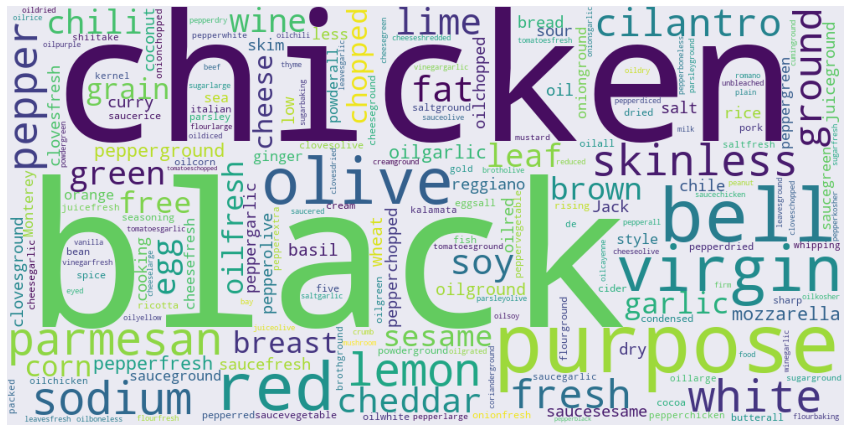

In [ ]:
raw_ingredients= [ing for ingredients in cuisine_df['ingredients'] for ing in ingredients] # list of all the ingredients in the dataset

## VISUALIZATION OF RAW INGREDIENTS

unique_string=('').join(raw_ingredients)
wordcloud= WordCloud(width= 1000, height= 500, background_color = '#eaeaf2', collocations = False).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Visualization of Symbols, Numbers, Etc.

THINGS TO BE CLEANED:
Symbos: ["  ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 ® â ç è é í î ú ’ € ™"]
Weird ingredientes: ['mi', 'mi', 'v8', 'v8']
Upper cases: ['Edam', 'French lentils', 'Royal Baking Powder', 'Rotel Diced Tomatoes & Green Chilies', 'Guinness Lager']
Apostrophes: ['Zatarain’s Jambalaya Mix', 'sheep’s milk cheese', 'Breakstone’s Sour Cream']
Hypens: ['wish-bone light asian sesame ginger vinaigrette dressing', 'reduced-fat cheese', 'tex-mex shredded cheese', 'all-purpose flour', 'high-fructose corn syrup']
Numbers: ['1% low-fat chocolate milk', '7 Up', 'KRAFT Mexican Style 2% Milk Finely Shredded Four Cheese', '2% reduced-fat milk', '40% less sodium taco seasoning mix']
Regionalisms: ['american cheese slices', 'american cheese slices', 'american cheese slices', 'american cheese food']


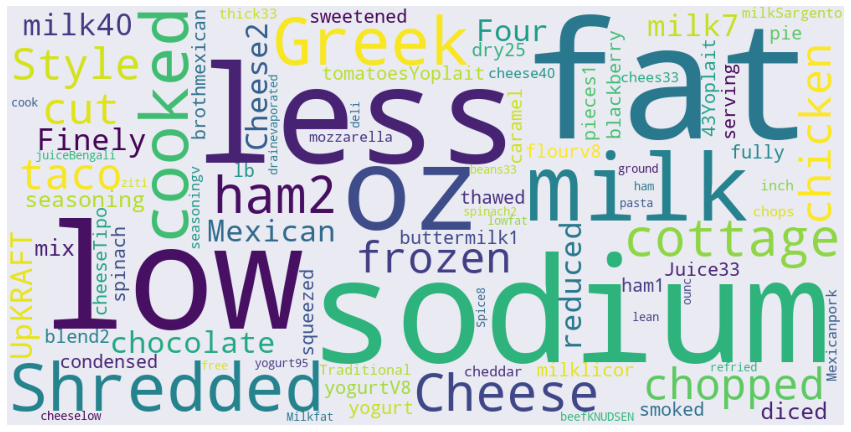

In [ ]:
### WEIRD SYMBOLS IDENTIFICATION AND VISUALIZATION
weird_symbols = [' '.join(sorted([char for char in set(' '.join(raw_ingredients)) if re.findall('[^A-Za-z]', char)]))]

wierd_ingredients = [ingredient for ingredient in raw_ingredients if len(ingredient) <= 2]

upper_cases = list(set([ingredient for ingredient in raw_ingredients if re.findall('[A-Z]+', ingredient)]))

apostrophes = list(set([ingredient for ingredient in raw_ingredients if '’' in ingredient]))

hypens = list(set([ingredient for ingredient in raw_ingredients if re.findall('-', ingredient)]))

numbers = list(set([ingredient for ingredient in raw_ingredients if re.findall('[0-9]', ingredient)]))

## REGIONS IDENTIFICATION
keywords = ['american', 'greek', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'chinese', 'thai',
    'vietnamese', 'cajun', 'creole', 'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian']
d = {}
for k in keywords:
    temp = [ingredient for ingredient in raw_ingredients if k in ingredient]
    d[k] = temp

print('THINGS TO BE CLEANED:')
print('Symbols:', weird_symbols)
print('Weird ingredientes:', wierd_ingredients)
print('Upper cases:', upper_cases[:5])
print('Apostrophes:', apostrophes)
print('Hyphens:', hypens[:5])
print('Numbers:', numbers[:5])
print('Regionalisms:', d['american'])

## VISUALIZATION####
symbols = [weird_symbols, wierd_ingredients, upper_cases, apostrophes, hypens, numbers]
for symbol in symbols:
    uniques = ('').join(symbol)

wordcloud = WordCloud(width = 1000, height = 500, background_color = '#eaeaf2', collocations = False).generate(uniques)
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Most Common Cuisine Types

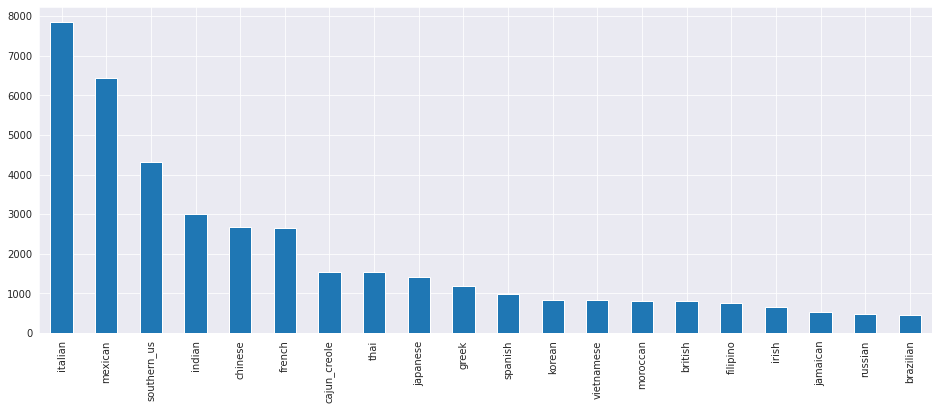

In [ ]:
## MOST COMMON CUISINE TYPES IN THE DATASET
cuisine_df['cuisine'].value_counts().plot.bar(figsize = (16, 6))

#### Number of Ingredients & Outliers

Text(0.5, 0, 'Number of Ingredients')

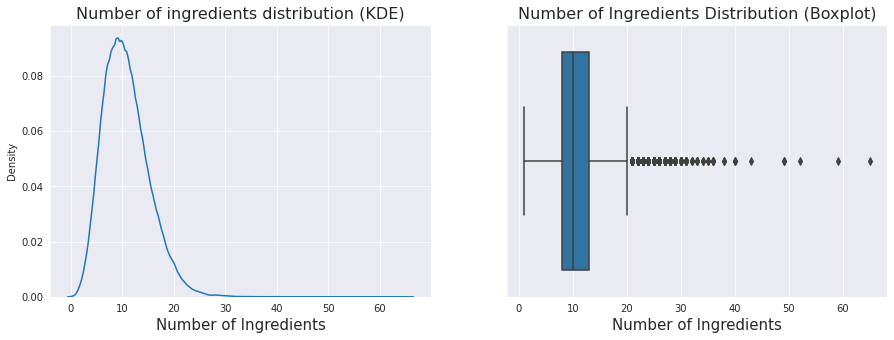

In [ ]:
### DISTRIBUTION OF THE NUMBER OF INGREDIENTS + OUTLIERS IDENTIFICATION:
cuisine_df['num_ing'] = cuisine_df['ingredients'].str.len()

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.kdeplot(x = cuisine_df['num_ing'], ax = ax[0]);
ax[0].set_title('Number of ingredients distribution (KDE)', fontsize = 16);
ax[0].set_xlabel('Number of Ingredients', fontsize = 15)

sns.boxplot(x = cuisine_df['num_ing'], ax = ax[1]);
ax[1].set_title('Number of Ingredients Distribution (Boxplot)', fontsize = 16);
plt.xlabel('Number of Ingredients', fontsize = 15)

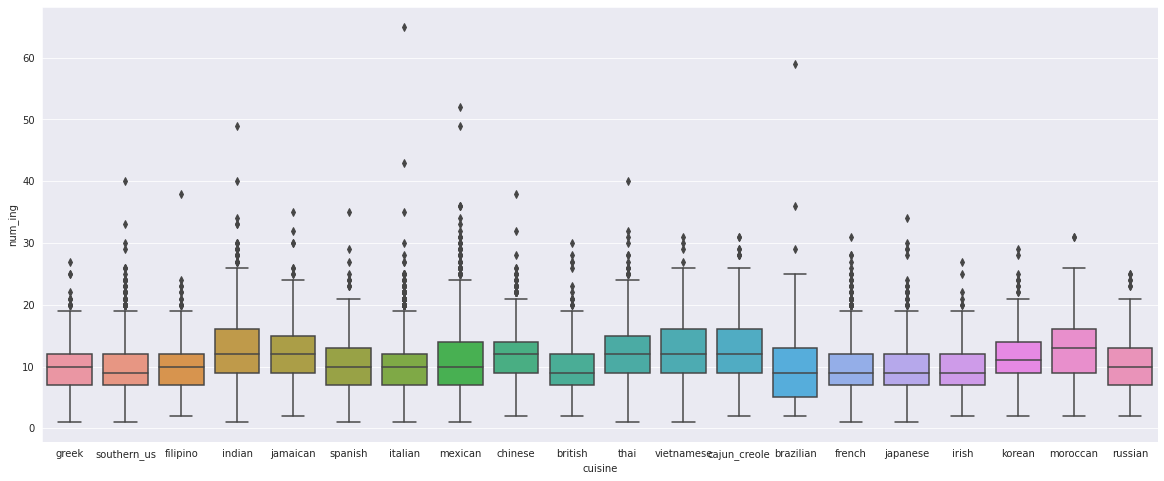

In [ ]:
## Outliers in number of ingredients for each cuisine. 
plt.figure(figsize = (20, 8))
sns.boxplot(x = 'cuisine', y = 'num_ing', data = cuisine_df)

Text(0, 0.5, 'Count')

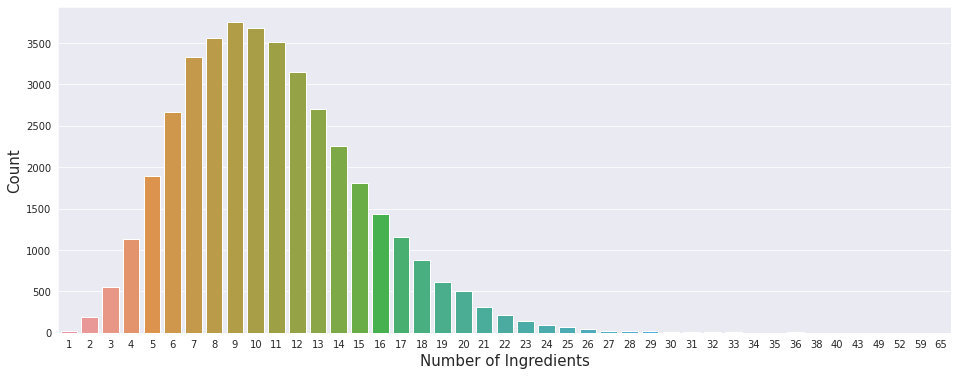

In [ ]:
plt.figure(figsize = (16, 6))
sns.countplot(x = 'num_ing', data = cuisine_df)
plt.xlabel('Number of Ingredients', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

In these visualizations, we identified outliers using the number of ingredients in each row of the dataset. Recipes with more than 30 ingredients and recipes with less than 2 ingredients were identified as outliers. Below, you can see what type of cuisines these recipes belongs to. 

In [ ]:
### OUTLIERS OF NUMBER OF INGREDIENTS >= 30.
longrecip = cuisine_df[cuisine_df['num_ing'] > 30]
print(len(longrecip), 'recipes with more than 30 ingredients')
## These are the cuisines with more than 30 ingredients. 
longrecip['cuisine'].value_counts()

40 recipes with more than 30 ingredients


mexican         12
indian           5
italian          3
thai             3
brazilian        2
moroccan         2
jamaican         2
cajun_creole     2
chinese          2
southern_us      2
french           1
japanese         1
spanish          1
filipino         1
vietnamese       1
Name: cuisine, dtype: int64

In [ ]:
## OUTLIERS OF NUMBER OF INGREDIENTS <=2
shortrecip = cuisine_df[cuisine_df['num_ing'] <= 2]
print(len(shortrecip), 'recipes with number or ingredients less or equal than 2')
print('the cuisine types of these short ingredients recipes')
shortrecip['cuisine'].value_counts()

215 recipes with number or ingredients less or equal than 2
the cuisine types of these short ingredients recipes


italian         37
french          34
southern_us     23
mexican         22
indian          19
japanese        16
vietnamese      11
chinese         10
spanish          8
cajun_creole     7
korean           5
thai             4
greek            4
british          3
brazilian        3
irish            3
filipino         3
jamaican         1
moroccan         1
russian          1
Name: cuisine, dtype: int64

### Data Cleaning & Preprocessing
1. Get rid of all weird symbols.
2. Get rid of outliers.
3. Lower casing.
4. Get rid of numbers.
5. Lemmatize.

In [ ]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower() #Lower - Casing
    ingredients_text = ingredients_text.replace('-', ' ') # Removing Hyphen
    words = []
    for word in ingredients_text.split():
        word = re.sub("[0-9]", " ", word) #removing numbers,punctuations and special characters
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word) # Removing Units
        if len(word) <= 2: continue # Removing words with less than two characters
        word = unidecode.unidecode(word) #Removing accents
        word = lemmatizer.lemmatize(word) #Lemmatize
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [ ]:
cuisine_df['ingredients_cleaned'] = cuisine_df['ingredients'].progress_apply(preprocess)
cuisine_df.head()

100%|██████████| 39774/39774 [00:07<00:00, 5138.65it/s]


,id,cuisine,ingredients,num_ing,ingredients_cleaned
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


In [ ]:
## REMOVING OUTLIERS
cuisine_df = cuisine_df[cuisine_df['num_ing'] > 1]
cuisine_df = cuisine_df[cuisine_df['num_ing'] <= 30]

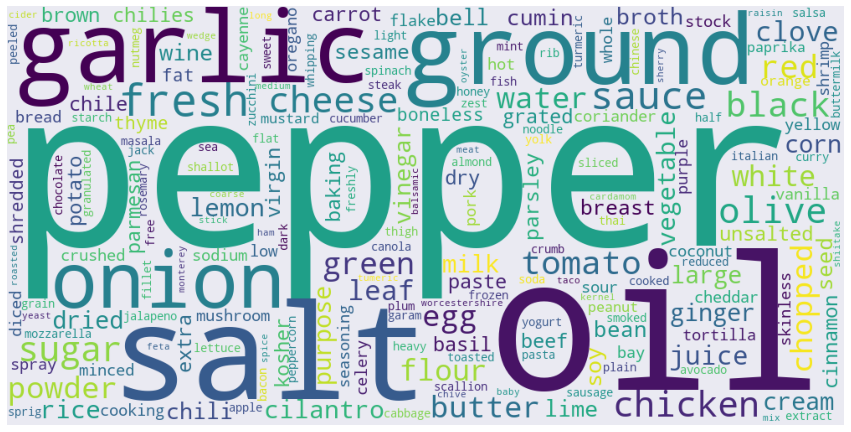

In [ ]:
cleaned_ingredients = [ingredient for ingredients in cuisine_df['ingredients_cleaned'] for ingredient in ingredients] # list of all the ingredients in the dataset

## VISUALIZATION OF CLEAN INGREDIENTS
clean_string = ('').join(cleaned_ingredients)
wordcloud= WordCloud(width = 1000, height = 500, background_color = '#eaeaf2', collocations = False).generate(clean_string)
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cuisine_df['ingredients_cleaned'],
    cuisine_df['cuisine'],
    test_size = 0.2,
    random_state = 1
)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape:  {X_test.shape}')

Training shape: (31769,)
Testing shape:  (7943,)


### Modeling
To get the best model, we iterated over several types of models and also performed hyperparameter tuning. The models tested for cuisine prediction are:

- Decision Tree
- Random Forest 
- Neural Network 
- Support Vector Classifier 
- AdaBoost Classifier
- K-neighbors Classfier 

The metric we used to evaluate is 'accuracy' with its highest value of 77% using SVC. After hyperparameter optimization, the accuracy improved to 79%. 

In [ ]:
# Helper functions
def plot_tuning_results(trials):
    with sns.axes_style('darkgrid'):
        fig = plt.figure(figsize = (25, 5))
        fig.subplots_adjust(wspace = 0.5)
        ax = fig.add_subplot(1, 3, 1)
        main_plot_histogram(trials, do_show = False);

        ax = fig.add_subplot(1, 3, 2)
        main_plot_history(trials, do_show = False);

def get_tuned_test_results(
    X_train, 
    y_train, 
    X_test,
    y_test, 
    search_space, 
    best_hyperparams, 
    model
):
    # Get the actual best hyperparameter values instead of 
    # just the indices and apply them to the pipeline
    best = space_eval(search_space, best_hyperparams)
    print(f'Best hyperparameters are: {best}')
    model = model.set_params(**best)

    # Get test results of best parameters
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_preds)
    print(f'Test Accuracy: {accuracy} ')

**Decision tree classifier**

In [ ]:
vectorizer = CountVectorizer()
model = tree.DecisionTreeClassifier()
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
scoring= ['accuracy']#, 'average_precision']#, 'average_precision', 'recall']
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = scoring,
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
#time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)

print(f'Cross-validation results: {cv_scores["test_accuracy"].tolist()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   59.8s finished


Cross-validation results: [0.6455775889203651, 0.6276361347182877, 0.6430594900849859, 0.6515580736543909, 0.6355051935788479, 0.6270066100094429, 0.6355051935788479, 0.6436890147938307, 0.6336166194523135, 0.6511335012594458]


**Random Forest Classifier**

In [ ]:
vectorizer = CountVectorizer()
model = RandomForestClassifier()
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
scoring= ['accuracy']#, 'average_precision']#, 'average_precision', 'recall']
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = scoring,
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
#time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)

print(f'Cross-validation results: {cv_scores["test_accuracy"].tolist()}')
#print(f'Average CV precision score:    {cv_scores["average_precision"].mean()}')
#print(f'Test accuracy score:          {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.3min finished


Cross-validation results: [0.7620396600566572, 0.7497639282341831, 0.7541706011960969, 0.7655020459553038, 0.7494491658797607, 0.7481901164620711, 0.7472458293988039, 0.7636134718287693, 0.7563739376770539, 0.7553526448362721]


**NeuralNet Classifier**

In [ ]:
vectorizer = CountVectorizer()
model =   MLPClassifier(alpha=1, max_iter=1000)
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
scoring= ['accuracy']#, 'average_precision']#, 'average_precision', 'recall']
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = scoring,
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
#time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)

print(f'Cross-validation results: {cv_scores["test_accuracy"].tolist()}')
#print(f'Average CV precision score:    {cv_scores["average_precision"].mean()}')
#print(f'Test accuracy score:          {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.3min finished


Cross-validation results: [0.7477987421383647, 0.720440251572327, 0.7286163522012579, 0.7336477987421384, 0.7345911949685534, 0.7314465408805031, 0.7276729559748427, 0.7349056603773585, 0.7364779874213836, 0.7345911949685534]


**Support Vector Classifier**

In [ ]:
vectorizer = CountVectorizer()
model =   SVC(
    #n_jobs = -1,
    random_state = 1)
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
scoring= ['accuracy']#, 'average_precision']#, 'average_precision', 'recall']
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = scoring,
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
#time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)

print(f'Cross-validation results: {cv_scores["test_accuracy"].tolist()}')
#print(f'Average CV precision score:    {cv_scores["average_precision"].mean()}')
#print(f'Test accuracy score:          {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 18.2min finished


Cross-validation results: [0.777148253068933, 0.7651872836008813, 0.7705382436260623, 0.777148253068933, 0.7695939565627951, 0.7752596789423984, 0.774944916587976, 0.7821844507396916, 0.7869058860560277, 0.7688916876574308]


**Ada Boost Classifier**

In [ ]:
vectorizer = CountVectorizer()
model =   AdaBoostClassifier()
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
scoring= ['accuracy']#, 'average_precision']#, 'average_precision', 'recall']
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = scoring,
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
#time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)

print(f'Cross-validation results: {cv_scores["test_accuracy"].tolist()}')
#print(f'Average CV precision score:    {cv_scores["average_precision"].mean()}')
#print(f'Test accuracy score:          {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   55.4s finished


Cross-validation results: [0.570125786163522, 0.5446540880503145, 0.5669811320754717, 0.5509433962264151, 0.5465408805031446, 0.5610062893081761, 0.5581761006289309, 0.5572327044025157, 0.5358490566037736, 0.559433962264151]


**K- Neighbors Classifiers**

In [ ]:
vectorizer = CountVectorizer()
model =   KNeighborsClassifier(10)
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
scoring= ['accuracy']#, 'average_precision']#, 'average_precision', 'recall']
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = scoring,
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
#time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_preds)

print(f'Cross-validation results: {cv_scores["test_accuracy"].tolist()}')
#print(f'Average CV precision score:    {cv_scores["average_precision"].mean()}')
#print(f'Test accuracy score:          {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.1s finished


Cross-validation results: [0.6427672955974842, 0.6314465408805031, 0.6433962264150943, 0.6537735849056604, 0.6474842767295598, 0.6625786163522013, 0.6569182389937107, 0.6525157232704403, 0.6490566037735849, 0.6487421383647799]


#### Best Model Hyperparameter Tuning
From the results above, we found the SVC to perform the best so now we try to tune it further.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_c = params['model__C']
    #model_degree = params['model__degree']
    #vec_analyzer = params['vectorizer__analyzer']
    #vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = CountVectorizer()
    model = SVC(
        C= model_c,
        #kernel= 'poly',
        #degree= model_degree,
        #n_jobs = -1,
        random_state = 1
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # Setting to 3-fold to save time
            scoring = 'accuracy'
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to minimize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
    'model__C': hp.choice('C', [10, 100]),
    #'model__degree': hp.choice('degree', [0,1,2,3,4,5,6]),
    #'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2), (2, 2)]),
    #'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

trials = Trials()
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = trials,
    max_evals = 15
)

100%|██████████| 15/15 [1:39:35<00:00, 398.34s/trial, best loss: -0.7778966764406784]


Showing Histogram of 15 jobs
avg best error: -0.7778966764406784


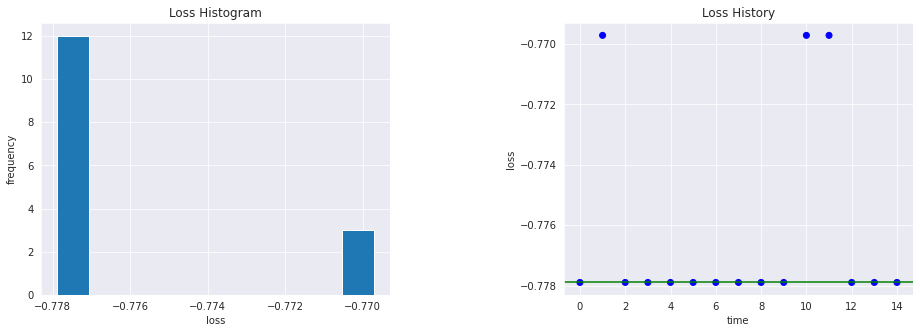

In [ ]:
plot_tuning_results(trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = CountVectorizer()
model = SVC(
    #n_jobs = -1,
    random_state = 1
)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline
)

Best hyperparameters are: {'model__C': 10}
Test Accuracy: 0.7928994082840237 


In [ ]:
vectorizer = CountVectorizer()
model = SVC(C = 10)
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

We see that the SVC improved after tuning. Now that we have the tuned pipeline, we save it as a JOBLIB file to use in our app.

In [ ]:
#########################
# PIPELINE - SVC        #
#########################
pipeline.fit(
     X = cuisine_df['ingredients_cleaned'],
     y = cuisine_df['cuisine']
 );
dump(pipeline, f'{data_dir}/cuisine_model.joblib');

## Calories Model
For this particular model, we will be taking a look at the nutritional data taken from here: https://www.kaggle.com/hugodarwood/epirecipes?select=full_format_recipes.json. We will focus on two main columns in this data: the target label (`calories`) and the ingredients list for each recipe. Because we want this model to use the same inputs as the cuisine-type model, we want to only use ingredients. The final outcome of this notebook is a saved model that takes in a list of ingredients and outputs the calorie count. The saved model will be used in a web app.

### Data Loading
We're loading data in from Google Drive so we have to mount our data for the notebook to see it.

In [ ]:
drive.mount('/data/', force_remount = True)
data_dir = '/data/My Drive/GWU/EMSE 6574/EMSE 6574 Final Project - Shared/Data'
!ls "{data_dir}"
calories_data = pd.read_json(f'{data_dir}/calories_data.json')
calories_data.head()

Mounted at /data/
calories_data.json     cuisine_data.json     cusine.db
calories_model.joblib  cuisine_model.joblib


,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


### Data Transformation
We are interested in two main fields: `ingredients` and `calories`. The `ingredients` field looks to be a list of strings so we need to transform that into something more usable. Let's transform the `ingredients` field into a string where each ingredient is separated by a newline character (`\n`).

In [ ]:
# Pull only the columns we're interested in
calories_data_filtered = calories_data[['calories', 'fat', 'protein', 'sodium', 'ingredients']]

# Let's make sure we also only use data that does not have NULLs
calories_data_filtered = calories_data_filtered.dropna().reset_index(drop = True)

# Transform `ingredients` column
calories_data_filtered['ingredients'] = calories_data_filtered['ingredients'].apply(
    lambda x: '\n'.join([ingredient for ingredient in x])
)

# Let's get a sample row to see if it's transformed properly
print(calories_data_filtered.sample(1)['ingredients'].values[0])

1 1/2 cups (3 sticks) butter, room temperature
2 cups sugar
8 eggs, separated, room temperature
10 ounces bittersweet or semisweet chocolate (do not exceed 61% cacao), melted, lukewarm
1 1/2 cups finely chopped pecans
2 teaspoons vanilla
1 teaspoon ground cinnamon
1 teaspoon ground cloves
1 teaspoon freshly grated nutmeg
1 1/3 cups unbleached all purpose flour, sifted (measured, then sifted)
Pinch of salt
Pinch of cream of tartar
3/4 cup sugar
1/2 cup light corn syrup
4 jumbo egg yolks
1 1/2 cups (3 sticks) butter, cut into small pieces, room temperature
6 ounces bittersweet or semisweet chocolate (do not exceed 61% cacao), melted and cooled (but still pourable)
1/4 cup dark rum
12 ounces bittersweet or semisweet chocolate (do not exceed 61% cacao), chopped
3/4 cup (1 1/2 sticks) unsalted butter, cut into 12 pieces
2 tablespoons honey
3/4 teaspoon instant espresso powder or instant coffee powder
7 ounces high-quality white chocolate (such as Lindt or Perugina), chopped
1/2 cup light co

### Exploratory Data Analysis
Now, let's do some exploratory data analysis on the two columns we're interested in.

#### Calories
Let's take a look at the `calories` column to see if there's anything interesting there.

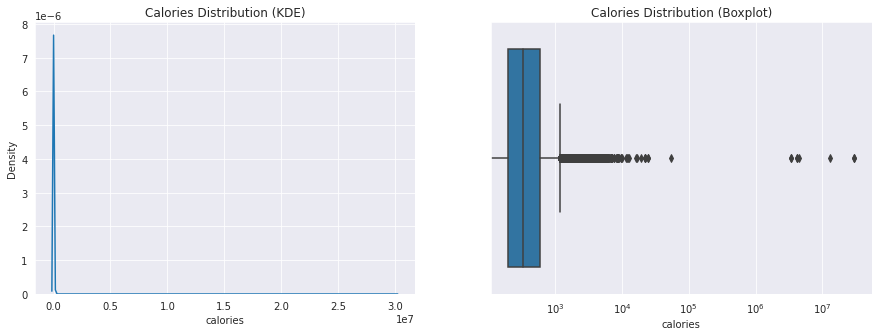

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.kdeplot(x = calories_data_filtered['calories'], ax = ax[0]);
ax[0].set_title('Calories Distribution (KDE)');

sns.boxplot(x = calories_data_filtered['calories'], ax = ax[1]);
ax[1].set_xscale('log'); # Set x-axis to log scale to better see boxplot
ax[1].set_title('Calories Distribution (Boxplot)');

Most of the data seems legitimate, but it looks like there are some values that are all the way up to 1E7 in magnitude! Let's get some basic stats around the `calories` column.

In [ ]:
calories_data_filtered['calories'].describe()

count    1.590300e+04
mean     6.336228e+03
std      3.594070e+05
min      0.000000e+00
25%      1.990000e+02
50%      3.330000e+02
75%      5.870000e+02
max      3.011122e+07
Name: calories, dtype: float64

The minimum number of calories looks to be 0 and the maximum number of calories looks to be 30,111,218. Those are some really extreme meals! As part of the feature engineering process, we should definitely **remove those values and other outlier values**.

If we look at the row that has the max calories value, we see that it also has ridiculously high values of fat, protein, and sodium. That's a killer recipe!

In [ ]:
calories_value = calories_data_filtered['calories'].max()
calories_data_filtered[calories_data_filtered['calories'] == calories_value]

,calories,fat,protein,sodium,ingredients
9062,30111218.0,1722763.0,200968.0,27675110.0,"2 firm-ripe Anjou pears, peeled, cored, and fi..."


In [ ]:
print(calories_data_filtered.iloc[9062, 4])

2 firm-ripe Anjou pears, peeled, cored, and finely chopped
1/2 cup dried sour cherries
1/2 cup dried currants
1/2 cup dried cranberries
1/2 cup packed light brown sugar
1/4 cup brandy
2 teaspoons finely grated fresh lemon zest
2 teaspoons finely grated fresh orange zest
2 tablespoons fresh lemon juice
1/2 teaspoon cinnamon
1/2 teaspoon ground allspice
1/4 teaspoon freshly grated nutmeg
1/8 teaspoon salt
3/4 cup walnuts (2 3/4 oz), toasted and finely chopped
Pastry dough for a double-crust pie


Let's see what it looks like when we plot calories versus the other nutritional information.

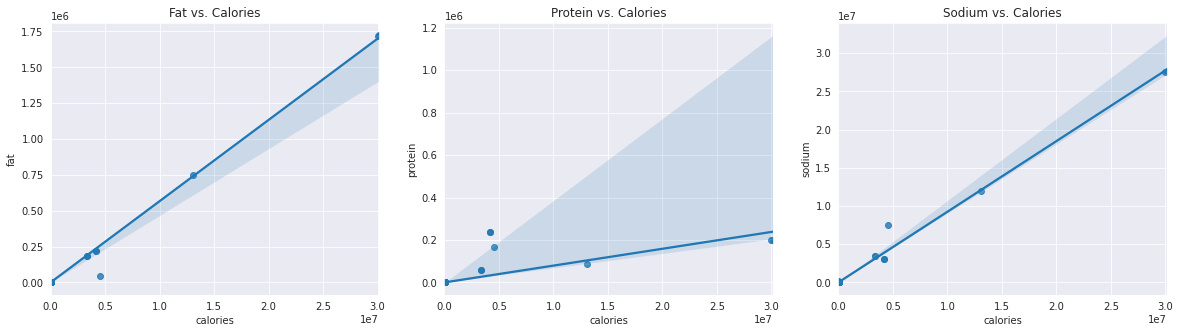

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
sns.regplot(data = calories_data_filtered, x = 'calories', y = 'fat', ax = axes[0]);
axes[0].set_title('Fat vs. Calories');

sns.regplot(data = calories_data_filtered, x = 'calories', y = 'protein', ax = axes[1]);
axes[1].set_title('Protein vs. Calories');

sns.regplot(data = calories_data_filtered, x = 'calories', y = 'sodium', ax = axes[2]);
axes[2].set_title('Sodium vs. Calories');

Definitely need to remove some outliers to see what the true relationships are.

In [ ]:
q1, q3 = np.percentile(calories_data_filtered['calories'], [25, 75])
iqr = q3 - q1
lower_range = q1 - 1.5 * iqr
upper_range = q3 + 1.5 * iqr
calories_data_outliers_removed = calories_data_filtered[
    ~((calories_data_filtered['calories'] < lower_range) | 
    (calories_data_filtered['calories'] > upper_range))
]
print(f'Shape before outlier removal: {calories_data_filtered.shape}')
print(f'Shape after outlier removal:  {calories_data_outliers_removed.shape}')

Shape before outlier removal: (15903, 5)
Shape after outlier removal:  (14886, 5)


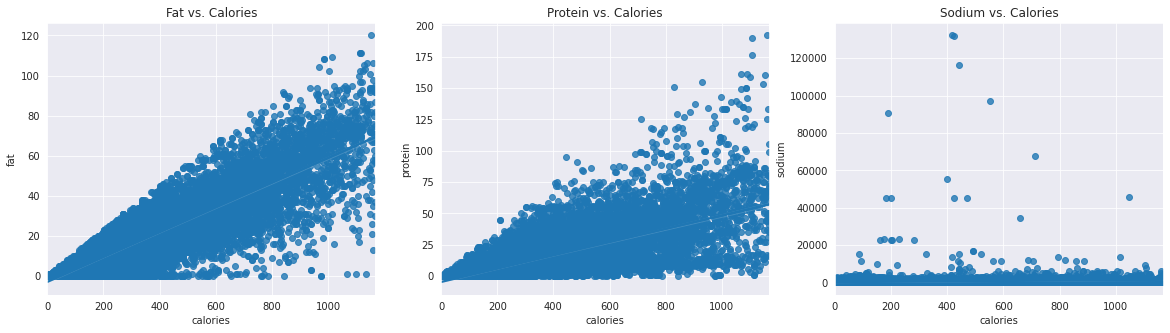

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
sns.regplot(data = calories_data_outliers_removed, x = 'calories', y = 'fat', ax = axes[0]);
axes[0].set_title('Fat vs. Calories');

sns.regplot(data = calories_data_outliers_removed, x = 'calories', y = 'protein', ax = axes[1]);
axes[1].set_title('Protein vs. Calories');

sns.regplot(data = calories_data_outliers_removed, x = 'calories', y = 'sodium', ax = axes[2]);
axes[2].set_title('Sodium vs. Calories');

Now we can clearly see there is a relationship between fat and calories. There is also a slight relationship between protein and calories, but there doesn't seem to be any relationship between sodium and calories.

#### Ingredients
Now let's take a look at the `ingredients` column. The first thing we look at is the most common words of the top 100 recipes sorted by calories using a word cloud. We also remove units (pounds, ounces, etc.). Numbers are kept because those may play an important part of determining calories.

In [ ]:
top_50_recipes_by_calories = calories_data_outliers_removed.sort_values('calories', ascending = False)[:100]
top_50_recipes_by_calories['ingredients_processed'] = top_50_recipes_by_calories['ingredients'].progress_apply(
    lambda x: re.sub('(oz|ounc|ounce|pound|pounds|lb|inch|inches|kg|to|cup|tablespoon|teaspoon|tablespoons|teaspoons)', '', x)
)

100%|██████████| 100/100 [00:00<00:00, 14904.60it/s]


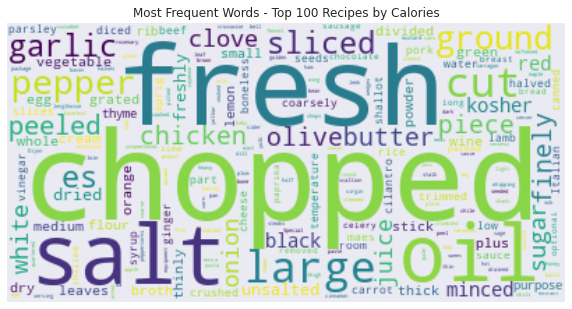

In [ ]:
# Generate the word cloud for ingredients.
text_ingredient = ' '.join(ingredient for ingredient in top_50_recipes_by_calories['ingredients_processed'])
wordcloud_ingredient = WordCloud(
    background_color = '#eaeaf2',
    collocations = False
).generate(text_ingredient)

# Display the generated image:
fig, axes = plt.subplots(1, 1, figsize = (10, 10))
axes.imshow(wordcloud_ingredient, interpolation = 'bilinear');
axes.axis('off');
axes.set_title('Most Frequent Words - Top 100 Recipes by Calories');

What about the relationship between word count in the ingredients list and calories? Is there anything interesting there? Based on the resulting graph, doesn't look like it.

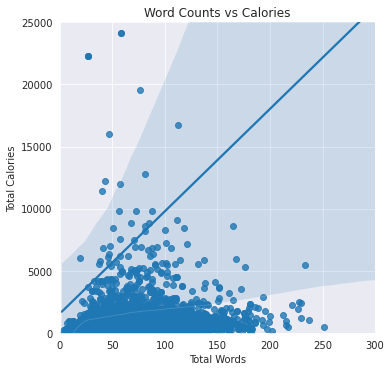

In [ ]:
def word_count(text):
    return len(text.split())

calories_data_filtered['total_words'] = calories_data_filtered['ingredients'] \
    .apply(lambda x: word_count(x))

# Graph the scatter plot with a regression line
g = sns.lmplot(x = 'total_words', y = 'calories', data = calories_data_filtered)

g = (
    g.set_axis_labels('Total Words', 'Total Calories').set(
        xlim = (0, 300), ylim = (0, 25000)
    )
)
plt.title('Word Counts vs Calories');

It doesn't look like there is any relationship between total characters in the ingredients list and calories. This is to be expected, but it would have been interesting to see if there was something there.

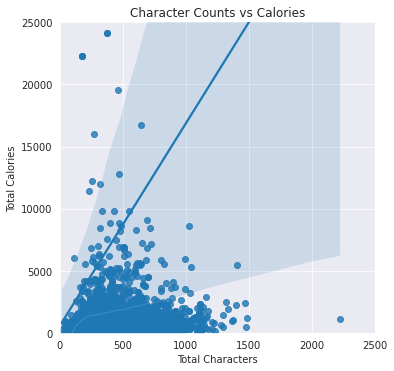

In [ ]:
def count_chars(txt):
	result = 0
	for char in txt:
		result += 1

	return result

calories_data_filtered['total_char'] = calories_data_filtered['ingredients'] \
	.apply(lambda x: count_chars(x))

# Plot the scatter plot with a regression line
g = sns.lmplot(x = 'total_char', y = 'calories', data = calories_data_filtered)

g = (
    g.set_axis_labels('Total Characters', 'Total Calories').set(
        xlim = (0, 2500), ylim = (0, 25000)
    )
)
plt.title('Character Counts vs Calories');

### Feature Engineering
Now that we have a better idea of what our data looks like, we can do some feature engineering to prepare the data for modeling. First, we'll treat the `calories` column and then we'll work with the `ingredients` column.

#### `calories`
We know there are some strange calorie values so let's remove those outlier values from the dataset.

In [ ]:
q1, q3 = np.percentile(calories_data_filtered['calories'], [25, 75])
iqr = q3 - q1
lower_range = q1 - 1.5 * iqr
upper_range = q3 + 1.5 * iqr
calories_data_engineered = calories_data_filtered[
    ~((calories_data_filtered['calories'] < lower_range) | 
    (calories_data_filtered['calories'] > upper_range))
].copy()
print(f'Shape before outlier removal: {calories_data_filtered.shape}')
print(f'Shape after outlier removal:  {calories_data_engineered.shape}')

Shape before outlier removal: (15903, 7)
Shape after outlier removal:  (14886, 7)


The removal of outliers now makes the distribution look a lot more normal which is good.

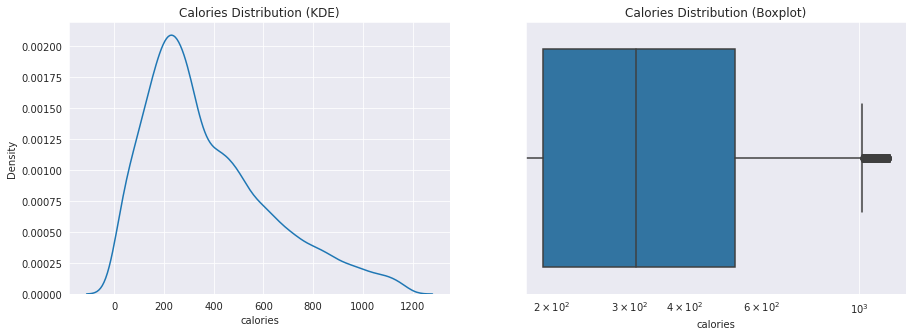

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.kdeplot(x = calories_data_engineered['calories'], ax = ax[0]);
ax[0].set_title('Calories Distribution (KDE)');

sns.boxplot(x = calories_data_engineered['calories'], ax = ax[1]);
ax[1].set_xscale('log'); # Set x-axis to log scale to better see boxplot
ax[1].set_title('Calories Distribution (Boxplot)');

#### `ingredients`
For the `ingredients` column, we just do some text preprocessing such as removing punctuation, removing stop words, and lemmatizing. This helps in making sure the text is "cleaner" and easier for the model to process.

In [ ]:
# Get the appropriate spaCy model to use.
spacy_model = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

################################
# TEXT PREPROCESSING FUNCTIONS #
################################
def _remove_punctuation(text, step):
    if step == 'initial':
        return [
            token for token in text if re.sub(r'[\W_]+', ' ', token.text)
            not in string.punctuation
            and re.sub(r'([\W_])+', ' ', token.text) != ' '
            and re.sub(r'([\W_])+', ' ', token.text) != ''
        ]
    elif step == 'last':
        return [re.sub(r'[\W_]+', ' ', token) for token in text]

def _remove_stop_words(text):
    return [token for token in text if not token.is_stop]

def _lemmatize(text):
    return [token.lemma_ for token in text]

def _remove_short_words(text):
    def __check_if_number(text):
        try:
            int(text)

            return True
        except:
            return False

    return [
        token for token in text 
        if len(token) > 2 or __check_if_number(token)
    ]

def preprocess_text(text):
    # Lowercase text and remove extra spaces.
    step_1_2 = ' '.join(
        [word.lower() for word in str(text).split()]
    )

    # Tokenize text with spaCy.
    step_3 = spacy_model(step_1_2)

    # Remove punctuation.
    step_4 = _remove_punctuation(step_3, step = 'initial')

    # Remove stop words.
    step_5 = _remove_stop_words(step_4)

    # Lemmatize text.
    step_6 = _lemmatize(step_5)

    # Remove punctuation again.
    step_7 = _remove_punctuation(step_6, step = 'last')

    # Remove words two characters or less.
    step_8 = _remove_short_words(step_7)

    # Remake sentence with new cleaned up tokens.
    return ' '.join(step_8)

# Start processing.
calories_data_engineered['ingredients_processed'] = calories_data_engineered['ingredients'] \
    .progress_apply(preprocess_text)

calories_data_engineered.head()

100%|██████████| 14886/14886 [01:13<00:00, 201.95it/s]


,calories,fat,protein,sodium,ingredients,total_words,total_char,ingredients_processed
0,426.0,7.0,30.0,559.0,4 cups low-sodium vegetable or chicken stock\n...,90,544,4 cup low sodium vegetable chicken stock 1 cup...
1,403.0,23.0,18.0,1439.0,"1 1/2 cups whipping cream\n2 medium onions, ch...",123,767,1 1 2 cup whip cream 2 medium onion chop 5 tea...
2,165.0,7.0,6.0,165.0,"1 fennel bulb (sometimes called anise), stalks...",39,243,1 fennel bulb call anise stalk discard bulb cu...
3,547.0,32.0,20.0,452.0,"1 12-ounce package frozen spinach soufflé, tha...",33,212,1 12 ounce package frozen spinach soufflé thaw...
4,948.0,79.0,19.0,1042.0,2 1/2 cups (lightly packed) fresh basil leaves...,51,331,2 1 2 cup lightly packed fresh basil leave 1 c...


### Train-Test Split
As is standard for all ML problems, we need to split our data into a train-test split. We do an 80/20 split here.

In [ ]:
# Do 80/20 train-test split.
X_train, X_test, y_train, y_test = train_test_split(
    calories_data_engineered['ingredients_processed'],
    calories_data_engineered['calories'],
    test_size = 0.2,
    random_state = 1
)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape:  {X_test.shape}')

Training shape: (11908,)
Testing shape:  (2978,)


### Modeling
For modeling, we're going to try out three different model iterations. The baseline model will first be a term-frequency-based elastic net model. The reason for choosing elastic net as our baseline is because it covers both L1 and L2-regularized regression just by changing the `l1_ratio` parameter, and we can also do a combination of both L1 and L2 regularization.

In [ ]:
# Helper functions
def plot_tuning_results(trials):
    with sns.axes_style('darkgrid'):
        fig = plt.figure(figsize = (25, 5))
        fig.subplots_adjust(wspace = 0.5)
        ax = fig.add_subplot(1, 3, 1)
        main_plot_histogram(trials, do_show = False);

        ax = fig.add_subplot(1, 3, 2)
        main_plot_history(trials, do_show = False);

def get_tuned_test_results(
    X_train, 
    y_train, 
    X_test,
    y_test, 
    search_space, 
    best_hyperparams, 
    model
):
    # Get the actual best hyperparameter values instead of 
    # just the indices and apply them to the pipeline
    best = space_eval(search_space, best_hyperparams)
    print(f'Best hyperparameters are: {best}')
    model = model.set_params(**best)

    # Get test results of best parameters
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    error = mean_squared_error(y_test, y_preds, squared = False)
    print(f'Test RMSE: {error} calories')

#### Baseline Model
As a starter, we make a baseline model to compare against. The metric we want to minimze is RMSE. In this case, our baseline model achieved an RMSE of 253.09. The negative is just how scikit-learn outputs the results so that their scoring metrics are consistent across their API: the higher the better.

In [ ]:
vectorizer = CountVectorizer()
model = ElasticNet(normalize = True, random_state = 1)
baseline_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])
cv_scores = cross_validate(
    estimator = baseline_pipeline, 
    X = X_train,
    y = y_train,
    scoring = 'neg_root_mean_squared_error',
    cv = 10,
    verbose = 3,
    n_jobs = -1
)
time.sleep(1)

baseline_pipeline.fit(X_train, y_train)
y_preds = baseline_pipeline.predict(X_test)
error = mean_squared_error(y_test, y_preds, squared = False)

print(f'Cross-validation results: {cv_scores["test_score"].tolist()}')
print(f'Average CV RMSE score:    {-cv_scores["test_score"].mean()}')
print(f'Test RMSE score:          {error}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.6s finished


Cross-validation results: [-256.0064282463566, -244.0143865318202, -256.7854187311806, -252.9364238373839, -251.28505073054723, -249.07061829545637, -246.99590881154998, -270.33287908053904, -252.47429836034584, -251.0740425405408]
Average CV RMSE score:    253.09754551657207
Test RMSE score:          256.02449752035443


##### Baseline Model Hyperparameter Tuning
Now that we have a baseline score, let's see if we can improve that score by doing some hyperparameter tuning on the `l1_ratio` parameter and the `CountVectorizer` parameters.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    model_l1_ratio = params['model__l1_ratio']
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = CountVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = ElasticNet(
        l1_ratio = model_l1_ratio,
        normalize = True,
        random_state = 1
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # Setting to 3-fold to save time
            scoring = 'neg_root_mean_squared_error'
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to minimize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
    'model__l1_ratio': hp.choice('l1_ratio', [0, 0.25, 0.5, 0.75, 1]),
    'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2), (2, 2)]),
    'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

trials = Trials()
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = trials,
    max_evals = 15
)

100%|██████████| 15/15 [1:09:33<00:00, 278.26s/trial, best loss: 249.94303560798627]


Showing Histogram of 15 jobs
avg best error: 249.94303560798627


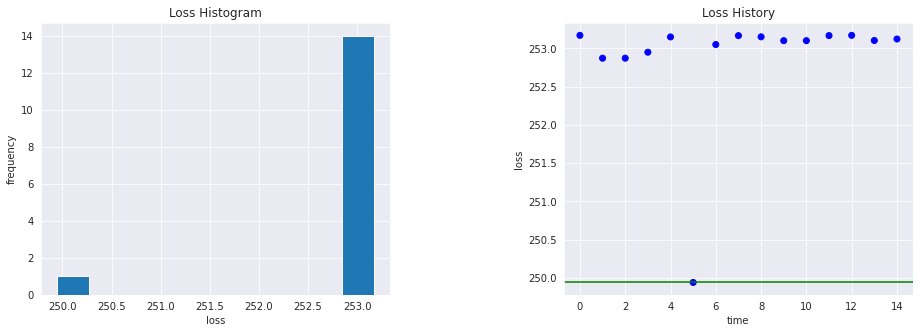

In [ ]:
plot_tuning_results(trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = CountVectorizer()
model = ElasticNet(
    normalize = True,
    random_state = 1
)
pipeline_1 = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline_1
)

Best hyperparameters are: {'model__l1_ratio': 1, 'vectorizer__analyzer': 'char_wb', 'vectorizer__ngram_range': (1, 1)}
Test RMSE: 256.02511585303745 calories


Looks like we were able to improve the score by a little, but let's see if another model does better.

#### Model Iteration 1: Random Forest
For this iteration, we switch out the elastic net for a random forest regressor. We go straight to the hyperparameter tuning to see if we can beat the hyperparameter-tuned version of the elastic net above.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']
    model_n_estimators = params['model__n_estimators']
    model_ccp_alpha = params['model__ccp_alpha']

    # Create the pipeline.
    vectorizer = CountVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = RandomForestRegressor(
        n_estimators = model_n_estimators,
        ccp_alpha = model_ccp_alpha,
        n_jobs = -1,
        random_state = 1
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # Reducing to 3-fold CV here to save time
            scoring = 'neg_root_mean_squared_error',
            n_jobs = -1
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to minimize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
    'model__n_estimators': hp.choice('n_estimators', [10, 25, 50, 100]),
    'model__ccp_alpha': hp.choice('ccp_alpha', [0, 0.1, 1, 10]),
    'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (2, 2)]),
    'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

trials = Trials()
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = trials,
    max_evals = 32
)

100%|██████████| 32/32 [2:57:02<00:00, 331.96s/trial, best loss: 196.44359289052605]


Showing Histogram of 32 jobs
avg best error: 196.44359289052605


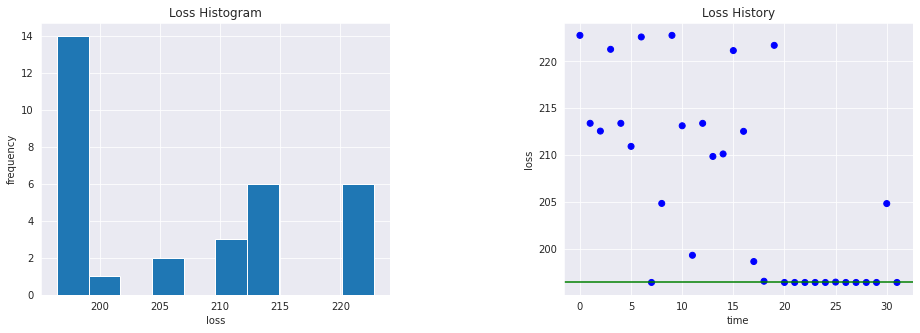

In [ ]:
plot_tuning_results(trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = CountVectorizer()
model = RandomForestRegressor(
    n_jobs = -1,
    random_state = 1
)
pipeline_2 = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline_2
)

Best hyperparameters are: {'model__ccp_alpha': 0, 'model__n_estimators': 50, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}
Test RMSE: 196.02772585200677 calories


Look at that! Looks like we were able to handily beat our baseline by a lot. Since it looks like the random forest regressor works well, let's see if we can improve upon it by switching out the vectorizer.

#### Model Iteration 2: TF-IDF
Now, instead of using the `CountVectorizer` which just returns term frequency, we'll test out the `TfidfVectorizer` which returns the TF-IDF vectorization of the words. We'll still use the random forest regressor since that beat the elastic net.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']
    model_n_estimators = params['model__n_estimators']
    model_ccp_alpha = params['model__ccp_alpha']

    # Create the pipeline.
    vectorizer = TfidfVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = RandomForestRegressor(
        n_estimators = model_n_estimators,
        ccp_alpha = model_ccp_alpha,
        n_jobs = -1,
        random_state = 1
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # Reducing to 3-fold CV here to save time
            scoring = 'neg_root_mean_squared_error',
            n_jobs = -1
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to minimize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
    'model__n_estimators': hp.choice('n_estimators', [10, 25, 50, 100]),
    'model__ccp_alpha': hp.choice('ccp_alpha', [0, 0.1, 1, 10]),
    'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (2, 2)]),
    'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

trials = Trials()
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = trials,
    max_evals = 32
)

100%|██████████| 32/32 [3:10:42<00:00, 357.57s/trial, best loss: 200.54891521235524]


Showing Histogram of 32 jobs
avg best error: 200.54891521235524


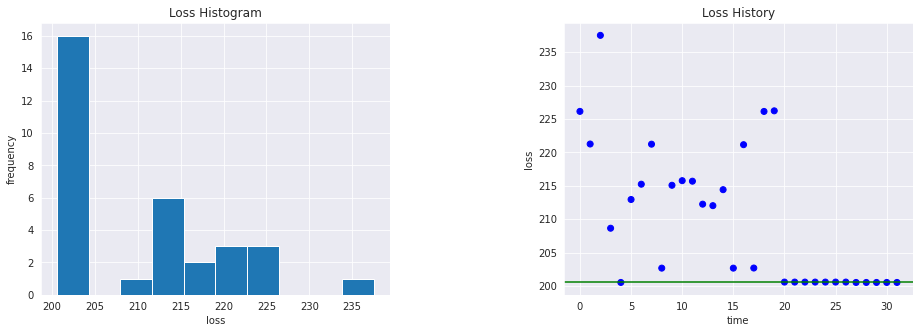

In [ ]:
plot_tuning_results(trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = TfidfVectorizer()
model = RandomForestRegressor(
    n_jobs = -1,
    random_state = 1
)
pipeline_3 = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline_3
)

Best hyperparameters are: {'model__ccp_alpha': 0.1, 'model__n_estimators': 50, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 1)}
Test RMSE: 200.19017631646898 calories


It doesn't look like the TD-IDF vectorizer brings any improvement to the model so we will stick with the `CountVectorizer`.

#### Model Iteration 3: Linear Regressor
This next iteration switches out the random forest regressor with the linear regressor. The linear regressor just performs a standard regression so it's nothing fancy, but it might perform fairly well. Since the `CountVectorizer` seems to be working the best, we will keep that vectorizer.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']

    # Create the pipeline.
    vectorizer = CountVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = LinearRegression(
        n_jobs = -1
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # Reducing to 3-fold CV here to save time
            scoring = 'neg_root_mean_squared_error',
            n_jobs = -1
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to minimize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
    'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2), (2, 2)]),
    'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

trials = Trials()
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = trials,
    max_evals = 6
)

100%|██████████| 6/6 [02:23<00:00, 23.93s/trial, best loss: 218.5910217420412]


Showing Histogram of 6 jobs
avg best error: 218.5910217420412


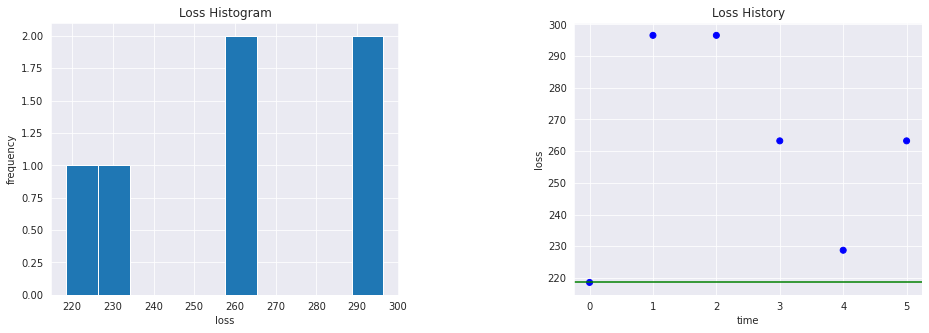

In [ ]:
plot_tuning_results(trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = CountVectorizer()
model = LinearRegression()
pipeline_4 = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline_4
)

Best hyperparameters are: {'vectorizer__analyzer': 'char_wb', 'vectorizer__ngram_range': (2, 2)}
Test RMSE: 218.09808852402244 calories


The linear regressor doesn't seem to perform as well as the random forest regressor. Doesn't look like a linear model works too well for this problem.

#### Model Iteration 4: Passive Aggressive Regressor
This next iteration switches out the linear regressor with the passive aggressive regressor.

In [ ]:
def objective_function(params):
    # Set the hyperparameters that we want to tune.
    vec_analyzer = params['vectorizer__analyzer']
    vec_ngrams = params['vectorizer__ngram_range']
    model_C = params['model__C']

    # Create the pipeline.
    vectorizer = CountVectorizer(
        analyzer = vec_analyzer,
        ngram_range = vec_ngrams
    )
    model = PassiveAggressiveRegressor(
        C = model_C,
        early_stopping = True,
        random_state = 1
    )
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('model', model)
    ])

    # Evaluate predictions.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_score = cross_val_score(
            estimator = pipeline, 
            X = X_train, 
            y = y_train,
            cv = 3, # Reducing to 3-fold CV here to save time
            scoring = 'neg_root_mean_squared_error',
            n_jobs = -1
        ).mean()

    # Clear up memory.
    del pipeline
    gc.collect();

    # Return metric as a negative value since we want to minimize it.
    return {'loss': -cv_score, 'status': STATUS_OK}

search_space = {
    'model__C': hp.choice('C', [0.001, 0.01, 0.1, 1, 10, 100, 1000]),
    'vectorizer__ngram_range': hp.choice('ngram_range', [(1, 1), (1, 2), (2, 2)]),
    'vectorizer__analyzer': hp.choice('analyzer', ['word', 'char_wb'])
}

trials = Trials()
best_hyperparams = fmin(
    fn = objective_function, 
    space = search_space,
    algo = tpe.suggest, 
    trials = trials,
    max_evals = 21
)

100%|██████████| 21/21 [01:39<00:00,  4.72s/trial, best loss: 211.21584898044532]


Showing Histogram of 21 jobs
avg best error: 211.21584898044532


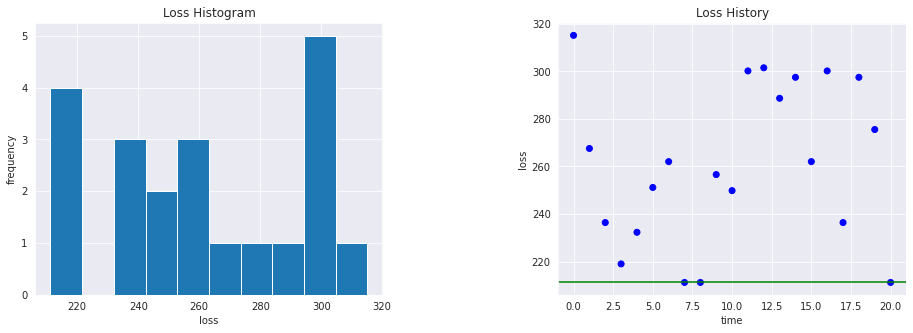

In [ ]:
plot_tuning_results(trials)

In [ ]:
# Defining the pipeline but not setting any parameters
# as that will be set below from the best hyperparameters
vectorizer = CountVectorizer()
model = PassiveAggressiveRegressor(
    early_stopping = True,
    random_state = 1
)
pipeline_5 = Pipeline([
    ('vectorizer', vectorizer),
    ('model', model)
])

get_tuned_test_results(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    search_space = search_space,
    best_hyperparams = best_hyperparams,
    model = pipeline_5
)

Best hyperparameters are: {'model__C': 1, 'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 2)}
Test RMSE: 210.18138724345653 calories


The passive aggressive regressor also did not perform as well as our random forest regressor so we will use that model pipeline.

Based on the results, model iteration 1 (random forest regressor with term frequency) did the best, beating our baseline RMSE by 60 calories (256.02 vs 196.02). Because of that, we will save this pipeline as a JOBLIB file to be used for a Streamlit app for future predictions.

### Final Model Training & Saving
Now that we know which model pipeline performs the best, we should train the model on the entire dataset and save it. Uncomment the section for the pipeline that performed the best below.

In [ ]:
#########################
# PIPELINE 1 - BASELINE #
#########################
# pipeline_1.fit(
#     X = calories_data_engineered['ingredients_processed'],
#     y = calories_data_engineered['calories']
# );
# dump(pipeline_1, f'{data_dir}/calories_model.joblib');

##################################
# PIPELINE 2 - MODEL ITERATION 1 #
##################################
pipeline_2.fit(
    X = calories_data_engineered['ingredients_processed'],
    y = calories_data_engineered['calories']
);
dump(pipeline_2, f'{data_dir}/calories_model.joblib');

##################################
# PIPELINE 3 - MODEL ITERATION 2 #
##################################
# pipeline_3.fit(
#     X = calories_data_engineered['ingredients_processed'],
#     y = calories_data_engineered['calories']
# );
# dump(pipeline_3, f'{data_dir}/calories_model.joblib');

##################################
# PIPELINE 4 - MODEL ITERATION 3 #
##################################
# pipeline_4.fit(
#     X = calories_data_engineered['ingredients_processed'],
#     y = calories_data_engineered['calories']
# );
# dump(pipeline_4, f'{data_dir}/calories_model.joblib');

##################################
# PIPELINE 5 - MODEL ITERATION 4 #
##################################
# pipeline_5.fit(
#     X = calories_data_engineered['ingredients_processed'],
#     y = calories_data_engineered['calories']
# );
# dump(pipeline_5, f'{data_dir}/calories_model.joblib');

The final app can be found here: https://share.streamlit.io/msalceda/emse-6574-final-project/main/final_project_app.py. Enter in your list of ingredients and see what our models predict for calories and cuisine type!

## Streamlit App Creation
The code for creating the app can be found here: https://github.com/msalceda/emse-6574-final-project.